# build molecule, taper and construct CS-VQE model

In [820]:
import json
import numpy as np
from symmer.chem import MoleculeBuilder
from symmer.projection import QubitTapering, CS_VQE, StabilizerIdentification
from symmer.symplectic import ObservableGraph, PauliwordOp

with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)    

speciesname = 'HF_STO-3G_SINGLET'
print(speciesname)
# build the molecule
mol_data = molecule_geometries[speciesname]
atoms  = mol_data['atoms']
coords = mol_data['coords']
charge = mol_data['charge']
basis = mol_data['basis']
geometry = list(zip(atoms, coords))
molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=0, run_fci=True, print_info=True)

HF_STO-3G_SINGLET
Molecule geometry:
H	0.0	0.0	0.099457
F	0.0	0.0	-0.895109

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -98.57101106797653
MP2 energy:  -98.59198165670853
CCSD energy: -98.60330177389838
FCI energy:  -98.60330177725882


Number of qubits: 12


In [821]:
# taper the Hamiltonian
qubit_tapering = QubitTapering(molecule.H_q)
hf_array = molecule.H_fermion.hf_comp_basis_state
qubit_tapering.stabilizers.update_sector(hf_array)
ham_tap = qubit_tapering.taper_it(ref_state=hf_array)
ucc_tap = qubit_tapering.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
hf_tapered = qubit_tapering.tapered_ref_state

print(f'Qubit tapering permitted a reduction of {molecule.H_q.n_qubits} -> {ham_tap.n_qubits} qubits\n')
print('The following stabilizers were identified:\n')
print(qubit_tapering.stabilizers)

Qubit tapering permitted a reduction of 12 -> 8 qubits

The following stabilizers were identified:

-1 ZIZIZIIZIZZI 
-1 IZIZIZIZIZIZ 
 1 IIIIIIZZIIII 
 1 IIIIIIIIZZII


In [822]:
n_qubits = 3
# CS-VQE and stabilizer identification
cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
CC_stabilizers = StabilizerIdentification(ucc_tap)
S = CC_stabilizers.symmetry_basis_by_subspace_dimension(n_qubits)
ham_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False)
ham_cs.to_PauliSumOp

PauliSumOp(SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ', 'IIX', 'IZX', 'ZIX', 'ZZX', 'IXI', 'IXZ', 'ZXI', 'ZXZ', 'IXX', 'IYY', 'ZXX', 'ZYY', 'XII', 'XIZ', 'XZI', 'XZZ', 'XIX', 'XZX', 'YIY', 'YZY', 'YYI', 'YYZ', 'XXX', 'XYY', 'YXY', 'YYX'],
              coeffs=[-95.78533118+0.j,   0.58777494+0.j,   0.82662245+0.j,   1.24655537+0.j,
   0.82662245+0.j,   1.24655537+0.j,   0.40122501+0.j,   0.3716758 +0.j,
  -0.02383106+0.j,   0.02383106+0.j,   0.02383106+0.j,  -0.02383106+0.j,
  -0.00328939+0.j,   0.00328939+0.j,  -0.05638561+0.j,   0.05638561+0.j,
   0.01334772+0.j,   0.01334772+0.j,  -0.01334772+0.j,  -0.01334772+0.j,
   0.00328939+0.j,  -0.00328939+0.j,   0.05638561+0.j,  -0.05638561+0.j,
  -0.01334772+0.j,   0.01334772+0.j,  -0.01334772+0.j,   0.01334772+0.j,
  -0.07720105+0.j,   0.07720105+0.j,  -0.04703229+0.j,  -0.04703229+0.j,
  -0.04703229+0.j,   0.04703229+0.j]), coeff=1.0)

In [823]:
from symmer.symplectic import AnsatzOp, ObservableOp

ucc_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False, aux_operator=ucc_tap)
ref_cs = hf_tapered[cs_vqe.free_qubit_indices]
anz_cs = AnsatzOp(ucc_cs.symp_matrix, ucc_cs.coeff_vec)

#ucc_trunc = ucc_cs#.sort()[:40]
#anz_cs = AnsatzOp(ucc_trunc.symp_matrix, ucc_trunc.coeff_vec)

#obs = ObservableOp(ham_cs.symp_matrix, ham_cs.coeff_vec)
#vqe_result = obs.VQE(
#    ansatz_op=anz_cs, 
#    ref_state=ref_cs
#)

#opt_params = vqe_result[0]['x']
#vqe_result[0]['fun'] - molecule.fci_energy

In [824]:
from qiskit import QuantumCircuit
ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
ansatz = ansatz.compose(anz_cs.to_QuantumCircuit(bind_params=False))
ansatz.draw()

░ ┌─────┐┌───┐┌─────────────┐┌───┐┌───┐ ░ ┌─────┐┌───┐     »
q_0: ──────░─┤ Sdg ├┤ H ├┤ Rz(-2*P[0]) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├──■──»
     ┌───┐ ░ └─────┘└───┘└─────────────┘└───┘└───┘ ░ └─────┘└───┘┌─┴─┐»
q_1: ┤ X ├─░───────────────────────────────────────░─────────────┤ X ├»
     ├───┤ ░                                       ░             └───┘»
q_2: ┤ X ├─░───────────────────────────────────────░──────────────────»
     └───┘ ░                                       ░                  »
«                         ┌───┐┌───┐ ░ ┌─────┐┌───┐                         »
«q_0: ─────────────────■──┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├──■───────────────────■──»
«     ┌─────────────┐┌─┴─┐└───┘└───┘ ░ └─────┘└───┘  │                   │  »
«q_1: ┤ Rz(-2*P[1]) ├┤ X ├───────────░───────────────┼───────────────────┼──»
«     └─────────────┘└───┘           ░             ┌─┴─┐┌─────────────┐┌─┴─┐»
«q_2: ───────────────────────────────░─────────────┤ X ├┤ Rz(-2*P[2]) ├┤ X ├»
«                                    ░             └───┘└─────────────┘└───┘»
«     ┌───┐┌───┐ ░ ┌─────┐┌───┐                                   ┌───┐┌───┐ ░ »
«q_0: ┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├──■─────────────────────────────■──┤ H ├┤ S ├─░─»
«     └───┘└───┘ ░ └─────┘└───┘┌─┴─┐                         ┌─┴─┐└───┘└───┘ ░ »
«q_1: ───────────░─────────────┤ X ├──■───────────────────■──┤ X ├───────────░─»
«                ░             └───┘┌─┴─┐┌─────────────┐┌─┴─┐└───┘           ░ »
«q_2: ───────────░──────────────────┤ X ├┤ Rz(-2*P[3]) ├┤ X ├────────────────░─»
«                ░                  └───┘└─────────────┘└───┘                ░ »
«     ┌─────┐┌───┐                         ┌───┐┌───┐ ░  ┌───┐           »
«q_0: ┤ Sdg ├┤ H ├──■───────────────────■──┤ H ├┤ S ├─░──┤ H ├────────■──»
«     └┬───┬┘└───┘┌─┴─┐┌─────────────┐┌─┴─┐├───┤└───┘ ░ ┌┴───┴┐┌───┐┌─┴─┐»
«q_1: ─┤ H ├──────┤ X ├┤ Rz(-2*P[4]) ├┤ X ├┤ H ├──────░─┤ Sdg ├┤ H ├┤ X ├»
«      └───┘      └───┘└─────────────┘└───┘└───┘      ░ └─────┘└───┘└───┘»
«q_2: ────────────────────────────────────────────────░──────────────────»
«                                                     ░                  »
«                         ┌───┐      ░ ┌─────┐┌───┐                         »
«q_0: ─────────────────■──┤ H ├──────░─┤ Sdg ├┤ H ├──■──────────────────────»
«     ┌─────────────┐┌─┴─┐├───┤┌───┐ ░ └┬───┬┘└───┘┌─┴─┐                    »
«q_1: ┤ Rz(-2*P[5]) ├┤ X ├┤ H ├┤ S ├─░──┤ H ├──────┤ X ├──■─────────────────»
«     └─────────────┘└───┘└───┘└───┘ ░  └───┘      └───┘┌─┴─┐┌─────────────┐»
«q_2: ───────────────────────────────░──────────────────┤ X ├┤ Rz(-2*P[6]) ├»
«                                    ░                  └───┘└─────────────┘»
«               ┌───┐┌───┐ ░  ┌───┐                                         »
«q_0: ───────■──┤ H ├┤ S ├─░──┤ H ├────────■─────────────────────────────■──»
«          ┌─┴─┐├───┤└───┘ ░ ┌┴───┴┐┌───┐┌─┴─┐                         ┌─┴─┐»
«q_1: ──■──┤ X ├┤ H ├──────░─┤ Sdg ├┤ H ├┤ X ├──■───────────────────■──┤ X ├»
«     ┌─┴─┐└───┘└───┘      ░ └─────┘└───┘└───┘┌─┴─┐┌─────────────┐┌─┴─┐└───┘»
«q_2: ┤ X ├────────────────░──────────────────┤ X ├┤ Rz(-2*P[7]) ├┤ X ├─────»
«     └───┘                ░                  └───┘└─────────────┘└───┘     »
«     ┌───┐      ░ ┌─────┐┌───┐                         ┌───┐┌───┐ ░ ┌─────┐»
«q_0: ┤ H ├──────░─┤ Sdg ├┤ H ├──■───────────────────■──┤ H ├┤ S ├─░─┤ Sdg ├»
«     ├───┤┌───┐ ░ └─────┘└───┘  │                   │  └───┘└───┘ ░ └─────┘»
«q_1: ┤ H ├┤ S ├─░───────────────┼───────────────────┼─────────────░────────»
«     └───┘└───┘ ░  ┌───┐      ┌─┴─┐┌─────────────┐┌─┴─┐┌───┐      ░  ┌───┐ »
«q_2: ───────────░──┤ H ├──────┤ X ├┤ Rz(-2*P[8]) ├┤ X ├┤ H ├──────░──┤ H ├─»
«                ░  └───┘      └───┘└─────────────┘└───┘└───┘      ░  └───┘ »
«     ┌───┐                                   ┌───┐┌───┐ ░  ┌───┐           »
«q_0: ┤ H ├──■─────────────────────────────■──┤ H ├┤ S ├─░──┤ H ├────────■──»
«     └───┘┌─┴─┐                         ┌─┴─┐└───┘└───┘ ░  └───┘        │ 

In [825]:
#from qiskit.quantum_info import Statevector
#from symmer.symplectic import QuantumState
#qc = ansatz.bind_parameters(opt_params)
#psi = Statevector.from_instruction(qc).to_dict()
#state_matrix, coeff_vec = zip(*[([int(i) for i in bstring], coeff) for bstring, coeff in psi.items()])
#state_matrix = np.array(state_matrix)
#coeff_vec = np.array(coeff_vec)

#psi = QuantumState(state_matrix, coeff_vec)
#psi.conjugate * ham_cs * psi - molecule.fci_energy

In [826]:
from qiskit.circuit.library import EfficientSU2
ansatz = EfficientSU2(n_qubits, reps=1)
ansatz.decompose().draw()

┌──────────┐┌──────────┐          ┌──────────┐┌──────────┐             
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├──■────■──┤ Ry(θ[6]) ├┤ Rz(θ[9]) ├─────────────
     ├──────────┤├──────────┤┌─┴─┐  │  └──────────┘├──────────┤┌───────────┐
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├┤ X ├──┼───────■──────┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├
     ├──────────┤├──────────┤└───┘┌─┴─┐   ┌─┴─┐    ├──────────┤├───────────┤
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├─────┤ X ├───┤ X ├────┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├
     └──────────┘└──────────┘     └───┘   └───┘    └──────────┘└───────────┘

In [827]:
#import qiskit.circuit.library.n_local as lib_local

#ansatz = getattr(lib_local, "EfficientSU2")
#ansatz(3).decompose().draw()

# VQE using ``symmer-vqe-Ve6OdoVd8X`` runtime program

In [828]:
from qiskit_ibm_runtime import QiskitRuntimeService
# only run the following the first time you connect to the service
#token = "a26e0769ddee03aa5f95f38edb1266efa1190059c7d60c1784ca3ec1e4c3c84bc375947c2bc8d2bc4ab39e32ea64ae6376b1f631936a416c7b8bdaed8b94a9cb"
#QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')

In [829]:
#program_id = service.upload_program(data="../../symmer/simulation/vqe_runtime.py", metadata=meta)
program_id = 'symmer-vqe-Ve6OdoVd8X'

In [830]:
#service.update_program(program_id=program_id, data="../../symmer/simulation/vqe_runtime.py", metadata=meta)
# service.delete_program(program_id) # to delete program

In [831]:
prog = service.program(program_id)
print(f'Program name: {prog.name}')
print(f'Description:  {prog.description}')

Program name: symmer_vqe
Description:  VQE program using symmer


In [832]:
operator = ham_cs

QWC_decomposition = list(
    ObservableGraph(
        operator.symp_matrix, 
        operator.coeff_vec
    ).clique_cover(
        clique_relation='QWC', 
        colouring_strategy='largest_first'
    ).values()
)
assert(sum(QWC_decomposition)==operator), 'Decomposition into QWC groups failed'

In [833]:
#for name in service.backends():
#    print(f'Backend name: {name.name: <29} | '+
#          f'Number of qubits: {name.num_qubits: <4} | '+
#          f'Number of jobs queued: {name.status().pending_jobs}'
#    )

In [950]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

#excitation_circuit = anz_cs.to_QuantumCircuit(bind_params=False)
excitation_circuit = EfficientSU2(n_qubits, su2_gates=['rx', 'ry'], entanglement='circular', reps=2, insert_barriers=True)

ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
ansatz.barrier()
ansatz = ansatz.compose(excitation_circuit)

ansatz.decompose().draw()

░ ┌──────────┐┌──────────┐ ░ ┌───┐           ░ ┌──────────┐»
q_0: ──────────────░─┤ Rx(θ[0]) ├┤ Ry(θ[3]) ├─░─┤ X ├──■────────░─┤ Rx(θ[6]) ├»
     ┌───────────┐ ░ ├──────────┤├──────────┤ ░ └─┬─┘┌─┴─┐      ░ ├──────────┤»
q_1: ┤ U3(π,0,π) ├─░─┤ Rx(θ[1]) ├┤ Ry(θ[4]) ├─░───┼──┤ X ├──■───░─┤ Rx(θ[7]) ├»
     ├───────────┤ ░ ├──────────┤├──────────┤ ░   │  └───┘┌─┴─┐ ░ ├──────────┤»
q_2: ┤ U3(π,0,π) ├─░─┤ Rx(θ[2]) ├┤ Ry(θ[5]) ├─░───■───────┤ X ├─░─┤ Rx(θ[8]) ├»
     └───────────┘ ░ └──────────┘└──────────┘ ░           └───┘ ░ └──────────┘»
«      ┌──────────┐ ░ ┌───┐           ░ ┌───────────┐┌───────────┐
«q_0: ─┤ Ry(θ[9]) ├─░─┤ X ├──■────────░─┤ Rx(θ[12]) ├┤ Ry(θ[15]) ├
«     ┌┴──────────┤ ░ └─┬─┘┌─┴─┐      ░ ├───────────┤├───────────┤
«q_1: ┤ Ry(θ[10]) ├─░───┼──┤ X ├──■───░─┤ Rx(θ[13]) ├┤ Ry(θ[16]) ├
«     ├───────────┤ ░   │  └───┘┌─┴─┐ ░ ├───────────┤├───────────┤
«q_2: ┤ Ry(θ[11]) ├─░───■───────┤ X ├─░─┤ Rx(θ[14]) ├┤ Ry(θ[17]) ├
«     └───────────┘ ░           └───┘ ░ └───────────┘└───────────┘

In [1210]:
2**14

16384

In [1243]:
backend_name = 'ibmq_qasm_simulator' #'ibm_nairobi'

options = {
    'backend_name': backend_name
}

inputs = {
    "ansatz": ansatz,
    "observable": ham_cs.to_PauliSumOp,
    "observable_groups": [op.to_PauliSumOp for op in QWC_decomposition],
    "init_params": vqe_result['x'],
    "optimizer": 'CG',
    "n_groups":5,
    "opt_setting": {"maxiter":10, "gtol": 1e-6},
    "n_shots": 2**13, # 18 < np.log2(0.0016**-2) < 19
    "n_realize":5
}

In [1244]:
job = service.run(
    program_id=program_id, 
    options=options, 
    inputs=inputs,
    instance='ibm-q/open/main'
)

In [1245]:
#service.backend(backend_name).status()

In [1246]:
print(f'Job ID: {job.job_id}')
print(f'Job status: {job.status()}')
#print(job.error_message())

Job ID: caq98o1ihlmte2bmndtg
Job status: JobStatus.QUEUED


In [1256]:
print(molecule.hf_energy, molecule.fci_energy)
job.interim_results()

-98.57101106797653 -98.60330177725882


['Optimization step #2: energy = -98.5684764814122',
 'Optimization step #1: gradient norm = 0.14559677639649712',
 'Optimization step #1: energy = -98.5826298087834',
 'Optimization commencing']

In [1248]:
vqe_result, interim_values = job.result()

KeyboardInterrupt: 

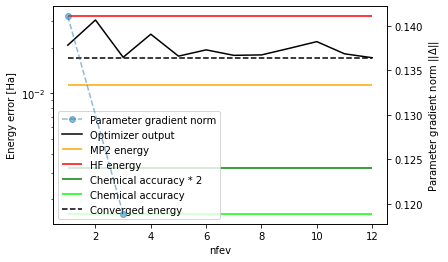

In [1242]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()
#while not job.status().value == 'job has successfully run':
X,Y = zip(*interim_values['values'])
X,Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 1, len(X), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 1, len(X), color='red', label='HF energy')
axis.hlines(2*0.0016, 1, len(X), color='green', label='Chemical accuracy * 2')
axis.hlines(0.0016, 1, len(X), color='lime', label='Chemical accuracy')
axis.plot([], [], alpha=0.5, marker='o', ls='--', label='Parameter gradient norm')


axis.plot(X, abs(Y - molecule.fci_energy), color='black', label='Optimizer output')
axis.hlines(abs(vqe_result['fun'] - molecule.fci_energy), 1, len(X), color='black', label='Converged energy', ls='--')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
axis.set_yscale('log')

try:
    axis_param = axis.twinx()
    X_grad, Y_grads = zip(*interim_values['gradients'])
    Y_grad_norm = [np.sqrt(np.sum(np.square(grad))) for grad in Y_grads]
    axis_param.plot(X_grad, Y_grad_norm, alpha=0.5, marker='o', ls='--')
    axis_param.set_ylabel('Parameter gradient norm $||\Delta||$')
    #for param_grad in zip(*Y_grads):
    #    axis_param.plot(X_grad, param_grad, alpha=0.2)
except:
    pass

axis.legend()
plt.show()

In [203]:
100_000/60/60 #hours

27.77777777777778

# program metadata

In [11]:
meta = {
    "name": "symmer_vqe",
    "description": "VQE program using symmer",
    "max_execution_time": 100000,
    "spec": {},
}

In [12]:
meta["spec"]["parameters"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "properties": {
        "ansatz": {
            "description": "Parametrized Ansatz",
            "type": "QuantumCircuit",
        },
        "observable_groups": {
            "description": "Decomposition of operator into groups, e.g. qubit-wise commuting",
            "type": "List[Union[PauliSumOp, PauliOp]]",
            "default": "None"
        },
        "observable": {
            "description": "The observable on which we wish to perform eigenvalue estimation",
            "type": "PauliSumOp",
            "default": "None",
        },
        "opt_setting": {
            "description": "Optimizer settings",
            "type": "dict",
            "default": "{'maxiter':10}",
        },
        "init_params": {
            "description": "Initial vector of parameters. This is a numpy array.",
            "type": "array",
            "default": "None",
        },
        "n_shots": {
            "description": "The number of shots used for each circuit evaluation.",
            "type": "integer",
            "default": "2**12",
        },
        "n_realize": {
            "description": "The number of realizations of each energy estimation - these are averaged over.",
            "type": "integer",
            "default": "1",
        },
        "n_groups": {
            "description": "The number of classical shadow groups.",
            "type": "integer",
            "default": "5",
        },
        "mitigate_errors": {
            "description": "Use matrix-free measurement mitigation (mthree), default=False.",
            "type": "boolean",
            "default": "False",
        },
    },
    "required": ["ansatz"],
}

meta["spec"]["return_values"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "description": "Tuple of final result in SciPy optimizer format and dictionary of interim values",
    "type": "Tuple[scipy.optimize.optimize.OptimizeResult, Dict]",
}

meta["spec"]["interim_results"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "description": "Parameter vector at current optimization step. This is a numpy array.",
    "type": "array",
}